In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.models import load_model

2023-12-01 00:11:15.883252: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
label_df = pd.read_csv('/scratch/kzr3fb/Data/metadata_compiled.csv')[['uuid','status']]

In [14]:
path = '/scratch/kzr3fb/Data'
healthy = list(label_df.loc[label_df['status']=='healthy'].uuid)
healthy = [path + '/' + x + '.wav' for x in healthy]
covid = list(label_df.loc[label_df['status']=='COVID-19'].uuid)
covid = [path + '/' + x + '.wav' for x in covid]

In [10]:
def load_wav(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    return wav, sample_rate

In [11]:
def preprocess(path):
    # call the wav data load function
    wav, sample_rate = load_wav(path)
    # Do the short-time Fourier Transform. 
    spectrogram = tf.signal.stft(wav, frame_length = 2048, frame_step = 512)
    # take absolute value of spectrogram
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    spectrogram = tf.image.resize(spectrogram,[512,512])
    image = tf.image.grayscale_to_rgb(spectrogram, name=None)
    image = tf.cast(image, dtype='uint8')
    #image = tf.io.decode_image(rgb_spectrogram)
    image = tf.image.rot90(image, 3)
    #rgb_spectrogram = tf.reshape(rgb_spectrogram,[512,512,3])
    #image = tf.image.resize(image, [224, 224])
    image = tf.image.adjust_contrast(image, 50 )
    image = tf.reshape(image, [512, 512, 3])
    return image

In [12]:
model=keras.models.load_model("/scratch/kzr3fb/DS6050_Project/VGG19_h5",compile=False)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        294976    
                                                                 
 global_average_pooling2d_1  (None, 64)                0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                      

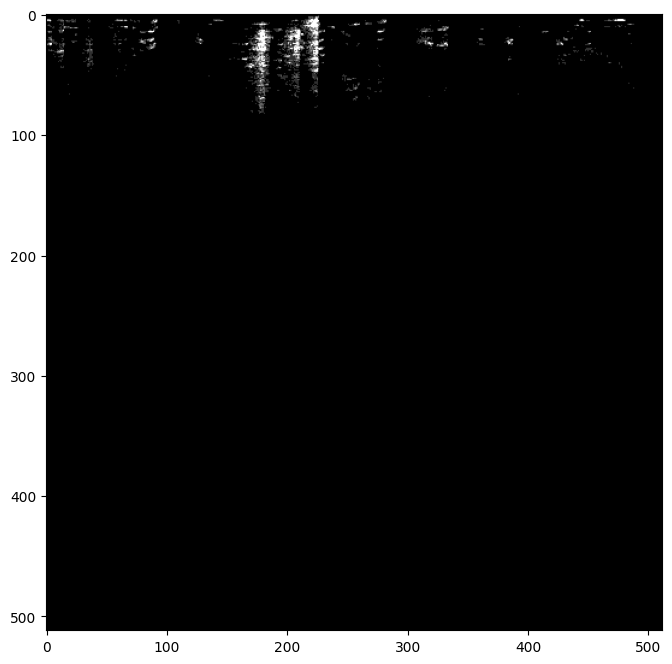

2023-12-01 00:15:36.447132: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904


1/1 [==============================] - 1s 908ms/step


array([0.98685324], dtype=float32)

In [15]:
image = preprocess(covid[0])
plt.figure(figsize=(8,8))
plt.imshow(image,cmap='gist_gray')
plt.grid(False)
plt.show()
model.predict(np.expand_dims(image, 0))[0]

In [23]:
len(healthy)

12479

In [61]:
covid[0].split('/')[-1][:-4]

'001d8e33-a4af-4edb-98ba-b03f891d9a6c'

In [62]:
predictions = pd.DataFrame()
for i,file in enumerate(covid):
    filename = file.split('/')[-1][:-4]
    
    try:
        x = preprocess(file)
        score = model.predict(np.expand_dims(x, 0),verbose=0)[0]
        predictions = pd.concat([predictions, pd.DataFrame({'filename':filename,'covid':1,'score':score},index=[i])])
    except:
        continue
    

2023-12-01 01:04:48.725086: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at whole_file_read_ops.cc:114 : NOT_FOUND: /scratch/kzr3fb/Data/1266d596-9264-45fb-8cff-296c0d404a35.wav; No such file or directory
2023-12-01 01:04:54.590265: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at whole_file_read_ops.cc:114 : NOT_FOUND: /scratch/kzr3fb/Data/2405a4e8-af80-4fbf-86c8-4ad9d1731acc.wav; No such file or directory
2023-12-01 01:04:59.496154: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at whole_file_read_ops.cc:114 : NOT_FOUND: /scratch/kzr3fb/Data/332ab58f-9728-4cea-9960-c49151120510.wav; No such file or directory
2023-12-01 01:05:01.201817: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at whole_file_read_ops.cc:114 : NOT_FOUND: /scratch/kzr3fb/Data/3a2ca593-e0c1-4edc-800e-41d009bf5650.wav; No such file or directory
2023-12-01 01:05:01.960490: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at

In [63]:
for i,file in enumerate(healthy):
    filename = file.split('/')[-1][:-4]
    try:
        x = preprocess(file)
        score = model.predict(np.expand_dims(x, 0),verbose=0)[0]
        predictions = pd.concat([predictions, pd.DataFrame({'filename':filename,'covid':0,'score':score},index=[i])])
    except:
        continue
    

2023-12-01 01:06:00.868533: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at whole_file_read_ops.cc:114 : NOT_FOUND: /scratch/kzr3fb/Data/005887c9-4bb1-4f13-86b2-1c7b3cee0881.wav; No such file or directory
2023-12-01 01:06:01.759498: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at whole_file_read_ops.cc:114 : NOT_FOUND: /scratch/kzr3fb/Data/009e762a-b4f7-41a6-a419-b4ca51be88ec.wav; No such file or directory
2023-12-01 01:06:01.759758: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at whole_file_read_ops.cc:114 : NOT_FOUND: /scratch/kzr3fb/Data/00a0156b-7179-4773-8a2c-4bb919e076bd.wav; No such file or directory
2023-12-01 01:06:01.759960: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at whole_file_read_ops.cc:114 : NOT_FOUND: /scratch/kzr3fb/Data/00a31212-7c64-4649-b78b-4c7d9ce3156e.wav; No such file or directory
2023-12-01 01:06:02.633159: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at

In [64]:
predictions = predictions.reset_index()

<Axes: xlabel='score', ylabel='Density'>

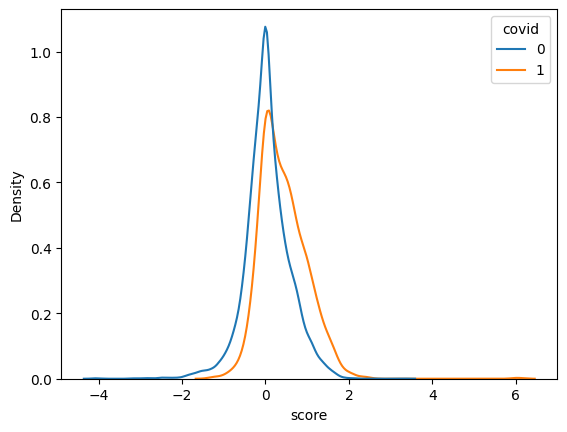

In [65]:
sns.kdeplot(data=predictions,x='score',hue='covid',common_norm=False)

In [66]:
predictions.head()

,index,filename,covid,score
0,0,001d8e33-a4af-4edb-98ba-b03f891d9a6c,1,0.986853
1,1,00357712-dd5a-4c0a-90a4-39f1f4b9d5fd,1,0.005177
2,2,00e0a33c-6561-406e-b543-4c9f07b860f7,1,-0.124921
3,3,01424527-9c3b-4b6e-96f1-9eea3150819b,1,-0.022270
4,4,015576c8-2b03-4dcb-b251-78a984fe86fe,1,-0.116273


In [67]:
len(predictions)

12824

In [68]:
predictions['filename'] = predictions['filename'].astype('str')

In [69]:
df = pd.read_csv('/scratch/kzr3fb/Data/metadata_compiled.csv')

In [70]:
df['uuid'] = df['uuid'].astype('str')

In [71]:
merged = predictions.merge(df, how='inner', left_on='filename',right_on='uuid')

In [72]:
merged.head()

,index,filename,covid,score,uuid,datetime,cough_detected,SNR,latitude,longitude,...,quality_4,cough_type_4,dyspnea_4,wheezing_4,stridor_4,choking_4,congestion_4,nothing_4,diagnosis_4,severity_4
0,0,001d8e33-a4af-4edb-98ba-b03f891d9a6c,1,0.986853,001d8e33-a4af-4edb-98ba-b03f891d9a6c,2020-05-13T01:27:42.552773+00:00,0.0306,12.713480,13.8,-89.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,00357712-dd5a-4c0a-90a4-39f1f4b9d5fd,1,0.005177,00357712-dd5a-4c0a-90a4-39f1f4b9d5fd,2020-04-10T12:48:17.554497+00:00,0.0576,0.000000,46.8,6.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,00e0a33c-6561-406e-b543-4c9f07b860f7,1,-0.124921,00e0a33c-6561-406e-b543-4c9f07b860f7,2020-04-15T07:01:51.945775+00:00,0.2798,12.695962,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,01424527-9c3b-4b6e-96f1-9eea3150819b,1,-0.022270,01424527-9c3b-4b6e-96f1-9eea3150819b,2020-10-18T15:51:28.858079+00:00,0.0000,16.047069,48.9,2.5,...,no_cough,NaN,False,False,False,False,False,False,NaN,NaN
4,4,015576c8-2b03-4dcb-b251-78a984fe86fe,1,-0.116273,015576c8-2b03-4dcb-b251-78a984fe86fe,2020-06-22T00:21:42.091345+00:00,1.0000,12.265701,NaN,NaN,...,good,unknown,False,False,False,False,False,True,obstructive_disease,mild


In [74]:
merged.to_csv('predicted data.csv')

In [73]:
len(merged)

12824

In [75]:
merged['status']

0        COVID-19
1        COVID-19
2        COVID-19
3        COVID-19
4        COVID-19
           ...   
12819     healthy
12820     healthy
12821     healthy
12822     healthy
12823     healthy
Name: status, Length: 12824, dtype: object

In [76]:
merged[['status','score']].groupby(by='status').mean()

,score
status,
COVID-19,0.425045
healthy,0.046326
